# 0 Importing Modules

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
import distributions
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU

Excerpt from Medvedev 2019: "GARCH family models tend to produce a term structure that reverts to the
long-term mean (Sinclair, 2013) and fails to capture the volatility skew (Dupire, 1994)...

Hansen and Lunde (2005), tested over 330 GARCH
family models, seeking to identify advantages of the more sophisticated models to a
standard GARCH(1,1) model...

The research found no evidence that more sophisticated
GARCH models significantly outperform the standard GARCH(1,1) model."

For each of the RNN architectures, I will follow a three 
    
    1. Train model (a) with Black-Scholes inputs to replicate the Black-Scholes Formula non-parametrically
    
    2. Construct model (b) based on the RNN architecture which takes historic returns as input, and outputs an IV value
    
    3. Compose model (b) to the IV input of model (a), and train the composed models

Chief concern is vanishing gradient in model (a) to (b)
To address this:
- Shallow model
- Try implementing first Black-Scholes equation before model

As extension I can also add market IV surface to model (b) input

In [2]:
"""
Making training, and testing datasets
Training set is SPY returns from 2014 to 2019
Testing set is SPY returns in 2019 
"""
split_date = "2019-01-01"
spy_returns = distributions.get_returns(["SPY"], "2014-01-01", "2020-01-01")
spy_data = pd.DataFrame({"Log Returns":spy_returns})
spy_data = spy_data.dropna(axis=0, how="all")
spy_data.index = pd.to_datetime(spy_data.index)
spy_data["Realized Volatility"] = distributions.get_realized_volatility(spy_data["Log Returns"])

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

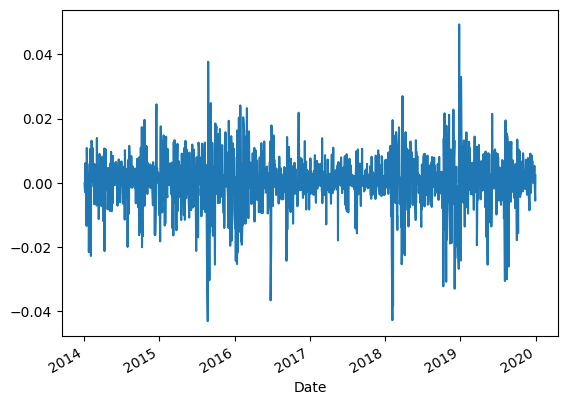

In [46]:
spy_data["Log Returns"].plot()

<Axes: xlabel='Date'>

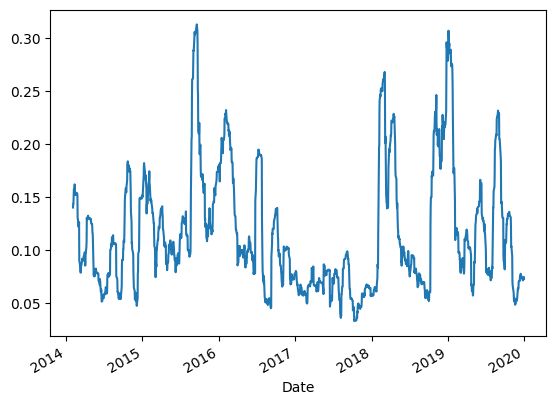

In [47]:
spy_data["Realized Volatility"].plot()

### 0.1 Data Preprocessing
Before using the data, it needs to be scaled to between 0 and 1, 
we'll use min-max scaling for this
We'll luse

### 0.1.1 Returns Preprocessing

In [48]:
returns_scaler = MinMaxScaler(feature_range=(0,1))
spy_data["Log Returns Scaled"] = returns_scaler.fit_transform(np.array(spy_data["Log Returns"]).reshape(-1, 1))

<Axes: xlabel='Date'>

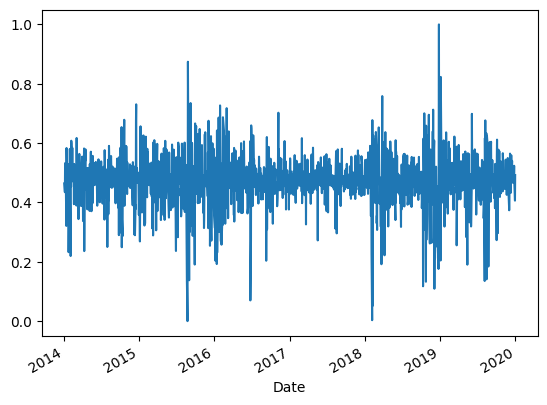

In [49]:
spy_data["Log Returns Scaled"].plot()

### 0.1.2 Volatility Preprocessing

In [50]:
vol_scaler = MinMaxScaler(feature_range=(0,1))
spy_data["Realized Volatility Scaled"] = vol_scaler.fit_transform(np.array(spy_data["Realized Volatility"]).reshape(-1, 1))

<Axes: xlabel='Date'>

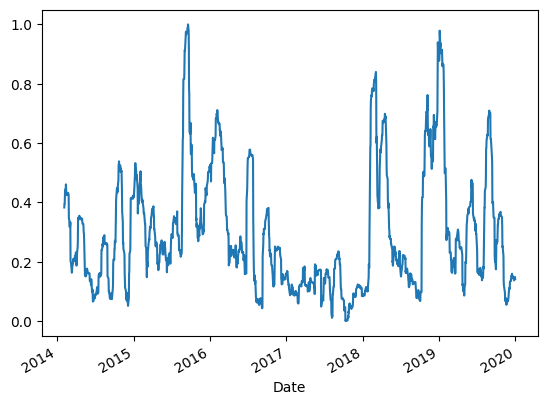

In [51]:
spy_data["Realized Volatility Scaled"].plot()

### 0.1.3 Creating Training Data
Forming `input_len` day sequences of training data

Forming `output_len` day sequences of target data

In [52]:
# Constants for model input and output length
returns_input_len = 60
returns_output_len = 21

returns_X_train = []
returns_y_train = []

for i in range(len(spy_data["Log Returns Scaled"][:split_date])-returns_input_len-returns_output_len):
    returns_X_train.append(list(spy_data["Log Returns Scaled"][:split_date][i:i+returns_input_len]))
    returns_y_train.append(list(spy_data["Log Returns Scaled"][:split_date][i+returns_input_len:i+returns_input_len+returns_output_len]))
returns_X_train, returns_y_train = np.array(returns_X_train), np.array(returns_y_train)
returns_X_train = np.reshape(returns_X_train, (returns_X_train.shape[0], returns_X_train.shape[1], 1))

In [53]:
# Displaying training data
fig = go.Figure(data=[
    go.Surface(
        z=np.hstack((returns_X_train.squeeze(-1), returns_y_train)),
        )
])

fig.update_layout(width=1000)

fig.show()

In [56]:
# Creating test data
returns_X_test = []
returns_y_test = []

for i in range(len(spy_data["Log Returns Scaled"][split_date:])-returns_input_len-returns_output_len):
    returns_X_test.append(spy_data["Log Returns Scaled"][split_date:][i:i+returns_input_len])
    returns_y_test.append(spy_data["Log Returns Scaled"][split_date:][i+returns_input_len:i+returns_input_len+returns_output_len])
returns_X_test, returns_y_test = np.array(returns_X_test), np.array(returns_y_test)
returns_X_test = np.reshape(returns_X_test, (returns_X_test.shape[0],returns_X_test.shape[1],1))

In [87]:
spy_data["Realized Volatility"]

Date
2014-01-03    0.0
2014-01-06    0.0
2014-01-07    0.0
2014-01-08    0.0
2014-01-09    0.0
             ... 
2019-12-24    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-30    0.0
2019-12-31    0.0
Name: Realized Volatility, Length: 1509, dtype: float64

In [70]:
vol_input_len = 60
vol_output_len = 21

vol_X_train = []
vol_y_train = []

for i in range(len(spy_data["Realized Volatility Scaled"][:split_date])-vol_input_len-vol_output_len):
    vol_X_train.append(spy_data["Realized Volatility Scaled"][:split_date][i:i+vol_input_len])
    vol_y_train.append(spy_data["Realized Volatility Scaled"][:split_date][i+vol_input_len:i+vol_input_len+vol_output_len])
vol_X_train, vol_y_train = np.array(vol_X_train), np.array(vol_y_train)
vol_X_train = np.reshape(vol_X_train, (vol_X_train.shape[0], vol_X_train.shape[1], 1))

In [72]:
#Making test data
vol_X_test = []
vol_y_test = []

for i in range(len(spy_data["Realized Volatility Scaled"][split_date:])-vol_input_len-vol_output_len):
    vol_X_test.append(spy_data["Realized Volatility Scaled"][split_date:][i:i+vol_input_len])
    vol_y_test.append(spy_data["Realized Volatility Scaled"][split_date:][i+vol_input_len:i+vol_input_len+vol_output_len])

vol_X_test, vol_y_test = np.array(vol_X_test), np.array(vol_y_test)
vol_X_test = np.reshape(vol_X_test, (vol_X_test.shape[0], vol_X_test.shape[1], 1))

# 1 LSTM Models

## 1.1 Modelling Mean Returns

### 1.1.1 Forming LSTM Model

In [57]:
lstm_returns_model = Sequential()

#First Layer including dropout regularization
lstm_returns_model.add(LSTM(units=100, return_sequences=True, input_shape=(returns_X_train.shape[1],1)))
lstm_returns_model.add(Dropout(0.3))

lstm_returns_model.add(LSTM(units=80, return_sequences=True))
lstm_returns_model.add(Dropout(0.1))

lstm_returns_model.add(LSTM(units=50, return_sequences=True))
lstm_returns_model.add(Dropout(0.2))

lstm_returns_model.add(LSTM(units=30))
lstm_returns_model.add(Dropout(0.3))

lstm_returns_model.add(Dense(units=returns_output_len))

lstm_returns_model.compile(optimizer='adam',loss='mean_squared_error')

In [58]:
lstm_returns_model.fit(returns_X_train, returns_y_train, epochs=50, batch_size=32)

Epoch 1/50
37/37 [==============================] - 5s 68ms/step - loss: 0.0757
Epoch 2/50
37/37 [==============================] - 3s 70ms/step - loss: 0.0327
Epoch 3/50
37/37 [==============================] - 3s 69ms/step - loss: 0.0259
Epoch 4/50
37/37 [==============================] - 3s 71ms/step - loss: 0.0214
Epoch 5/50
37/37 [==============================] - 3s 69ms/step - loss: 0.0189
Epoch 6/50
37/37 [==============================] - 3s 70ms/step - loss: 0.0173
Epoch 7/50
37/37 [==============================] - 3s 70ms/step - loss: 0.0160
Epoch 8/50
37/37 [==============================] - 3s 71ms/step - loss: 0.0150
Epoch 9/50
37/37 [==============================] - 3s 69ms/step - loss: 0.0139
Epoch 10/50
37/37 [==============================] - 3s 71ms/step - loss: 0.0134
Epoch 11/50
37/37 [==============================] - 3s 72ms/step - loss: 0.0129
Epoch 12/50
37/37 [==============================] - 3s 76ms/step - loss: 0.0126
Epoch 13/50
37/37 [==================

### 1.1.2 Testing Model

In [33]:
spy_data[["Log Returns", "Log Returns Scaled"]]

,Log Returns,Log Returns Scaled
Date,,
2014-01-03,-0.000164,0.464260
2014-01-06,-0.002902,0.434591
2014-01-07,0.006123,0.532362
2014-01-08,0.000218,0.468399
2014-01-09,0.000654,0.473115
...,...,...
2019-12-24,0.000031,0.466370
2019-12-26,0.005309,0.523547
2019-12-27,-0.000248,0.463352


In [59]:
# Predicting test data
predicted_returns_transformed = lstm_returns_model.predict(returns_X_test)
predicted_returns = returns_scaler.inverse_transform(predicted_returns_transformed)

6/6 [==============================] - 1s 22ms/step


In [66]:
# Displaying results
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'is_3d': True}, {'is_3d': True}]],
                    subplot_titles=['21 Step Predicted Returns', 'Returns'],
                    )

fig.add_trace(go.Surface(z=predicted_returns),
    1, 1
)

fig.add_trace(go.Surface(z=returns_scaler.inverse_transform(returns_y_test), opacity=0.9),
    1, 2
)

fig.show()

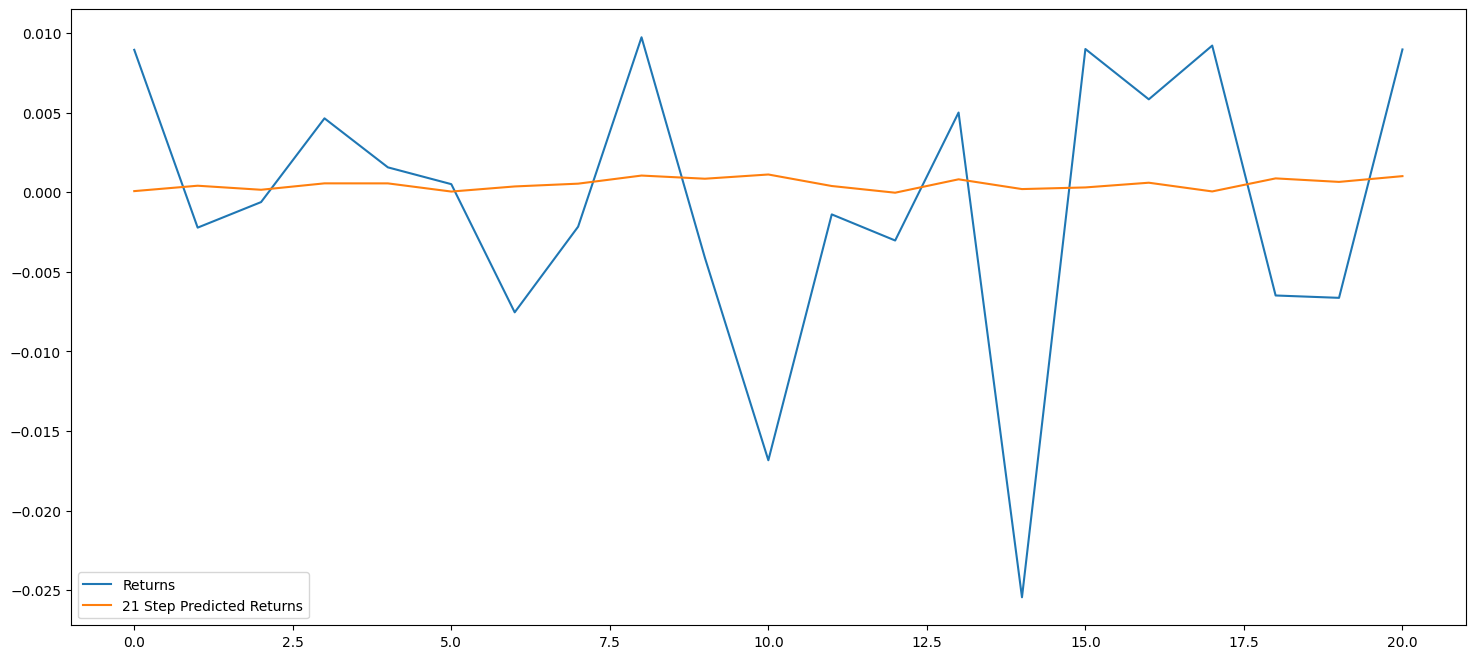

In [67]:
# 2D Results Plot
fig = plt.figure(figsize=(18,8))
test_index = 16
plt.plot(returns_scaler.inverse_transform(returns_y_test[test_index].reshape(-1, 1)))
plt.plot(predicted_returns[test_index])
plt.legend(["Returns", "21 Step Predicted Returns"])

## 1.2 Modelling One Step Returns Variance

### 1.2.1 Forming Model

In [75]:
lstm_vol_model = Sequential()

#First Layer including dropout regularization
lstm_vol_model.add(LSTM(units=100, return_sequences=True, input_shape=(vol_X_train.shape[1],1)))
lstm_vol_model.add(Dropout(0.3))

lstm_vol_model.add(LSTM(units=80, return_sequences=True))
lstm_vol_model.add(Dropout(0.1))

lstm_vol_model.add(LSTM(units=50, return_sequences=True))
lstm_vol_model.add(Dropout(0.2))

lstm_vol_model.add(LSTM(units=30))
lstm_vol_model.add(Dropout(0.3))

lstm_vol_model.add(Dense(units=1))

lstm_vol_model.compile(optimizer='adam',loss='mean_squared_error')

In [76]:
lstm_vol_model.fit(vol_X_train, vol_y_train, epochs=50, batch_size=32)

Epoch 1/50
37/37 [==============================] - 5s 62ms/step - loss: nan
Epoch 2/50
37/37 [==============================] - 2s 59ms/step - loss: nan
Epoch 3/50
37/37 [==============================] - 2s 62ms/step - loss: nan
Epoch 4/50
37/37 [==============================] - 2s 68ms/step - loss: nan
Epoch 5/50
37/37 [==============================] - 3s 68ms/step - loss: nan
Epoch 6/50
37/37 [==============================] - 2s 66ms/step - loss: nan
Epoch 7/50
37/37 [==============================] - 2s 66ms/step - loss: nan
Epoch 8/50
37/37 [==============================] - 2s 66ms/step - loss: nan
Epoch 9/50
37/37 [==============================] - 3s 87ms/step - loss: nan
Epoch 10/50
37/37 [==============================] - 2s 67ms/step - loss: nan
Epoch 11/50
37/37 [==============================] - 2s 67ms/step - loss: nan
Epoch 12/50
37/37 [==============================] - 3s 75ms/step - loss: nan
Epoch 13/50
37/37 [==============================] - 3s 71ms/step - loss:

In [77]:
predicted_vol_transformed = lstm_vol_model.predict(vol_X_test)
predicted_vol = vol_scaler.inverse_transform(predicted_vol_transformed)

6/6 [==============================] - 1s 16ms/step


### 1.2.2 Testing Model

In [ ]:
# Displaying results
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'is_3d': True}, {'is_3d': True}]],
                    subplot_titles=['21 Step Predicted Volatility', 'Realized Volatility'],
                    )

fig.add_trace(go.Surface(z=predicted_vol),
    1, 1
)

fig.add_trace(go.Surface(z=returns_scaler.inverse_transform(vol_y_test), opacity=0.9),
    1, 2
)

fig.show()

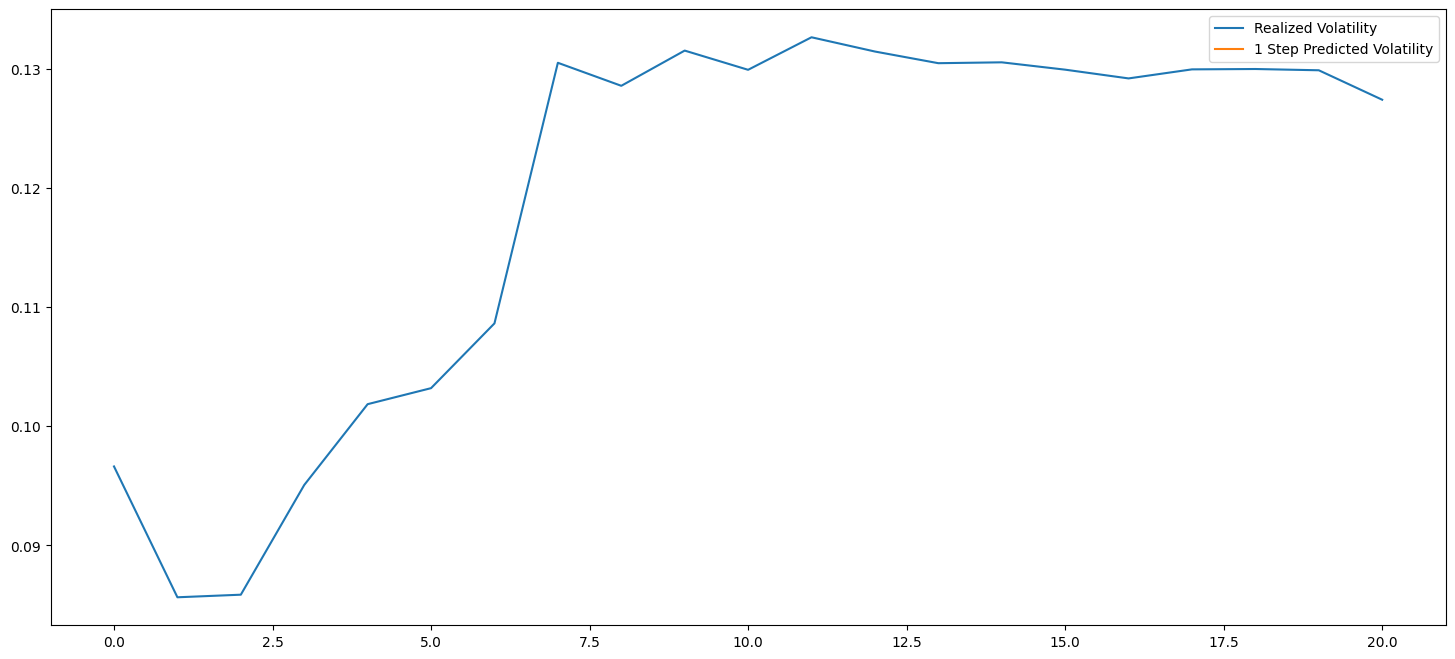

In [78]:
fig = plt.figure(figsize=(18,8))
test_index = 0
plt.plot(vol_scaler.inverse_transform(vol_y_train[test_index].reshape(-1, 1)))
plt.plot(predicted_vol[test_index])
plt.legend(["Realized Volatility", "1 Step Predicted Volatility"])

# 2 GRU Models 

## 2.1 Modelling One Step Mean Returns

### 2.1.2 Creating Training Data

In [106]:
training_len = 60
X_train = []
y_train = []

X_train = [window for window in spy_data["Log Returns Scaled"][:split_date].rolling(window=training_len)][training_len-1:-1]
y_train = spy_data["Log Returns Scaled"][:split_date][training_len:]
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### 2.1.3 Forming GRU Model

In [107]:
gru_returns_model = Sequential()

#First GRU Layer
gru_returns_model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_returns_model.add(Dropout(0.3))

#Second GRU Layer
gru_returns_model.add(GRU(units=80, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_returns_model.add(Dropout(0.2))

#Third GRU Layer
gru_returns_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_returns_model.add(Dropout(0.1))

#Fourth GRU Layer
gru_returns_model.add(GRU(units=30, activation='tanh'))
gru_returns_model.add(Dropout(0.2))

#Output Layer
gru_returns_model.add(Dense(units=1))

#Compiling RNN
gru_returns_model.compile(optimizer='adam', loss='mean_squared_error')

In [108]:
#Fitting Model
gru_returns_model.fit(X_train, y_train, epochs=50, batch_size=150)

Epoch 1/50
8/8 [==============================] - 9s 158ms/step - loss: 0.0722
Epoch 2/50
8/8 [==============================] - 1s 151ms/step - loss: 0.0195
Epoch 3/50
8/8 [==============================] - 1s 155ms/step - loss: 0.0138
Epoch 4/50
8/8 [==============================] - 1s 164ms/step - loss: 0.0132
Epoch 5/50
8/8 [==============================] - 1s 154ms/step - loss: 0.0125
Epoch 6/50
8/8 [==============================] - 1s 159ms/step - loss: 0.0118
Epoch 7/50
8/8 [==============================] - 1s 163ms/step - loss: 0.0117
Epoch 8/50
8/8 [==============================] - 1s 151ms/step - loss: 0.0113
Epoch 9/50
8/8 [==============================] - 1s 151ms/step - loss: 0.0112
Epoch 10/50
8/8 [==============================] - 2s 190ms/step - loss: 0.0118
Epoch 11/50
8/8 [==============================] - 1s 158ms/step - loss: 0.0113
Epoch 12/50
8/8 [==============================] - 1s 156ms/step - loss: 0.0108
Epoch 13/50
8/8 [==============================] 

### 2.1.4 Testing Model

In [109]:
#Making test data
X_test = []

X_test = [window for window in spy_data["Log Returns Scaled"][split_date:].rolling(window=training_len)][training_len-1:-1]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_returns_transformed = gru_returns_model.predict(X_test)
predicted_returns = returns_scaler.inverse_transform(predicted_returns_transformed)

6/6 [==============================] - 27s 65ms/step


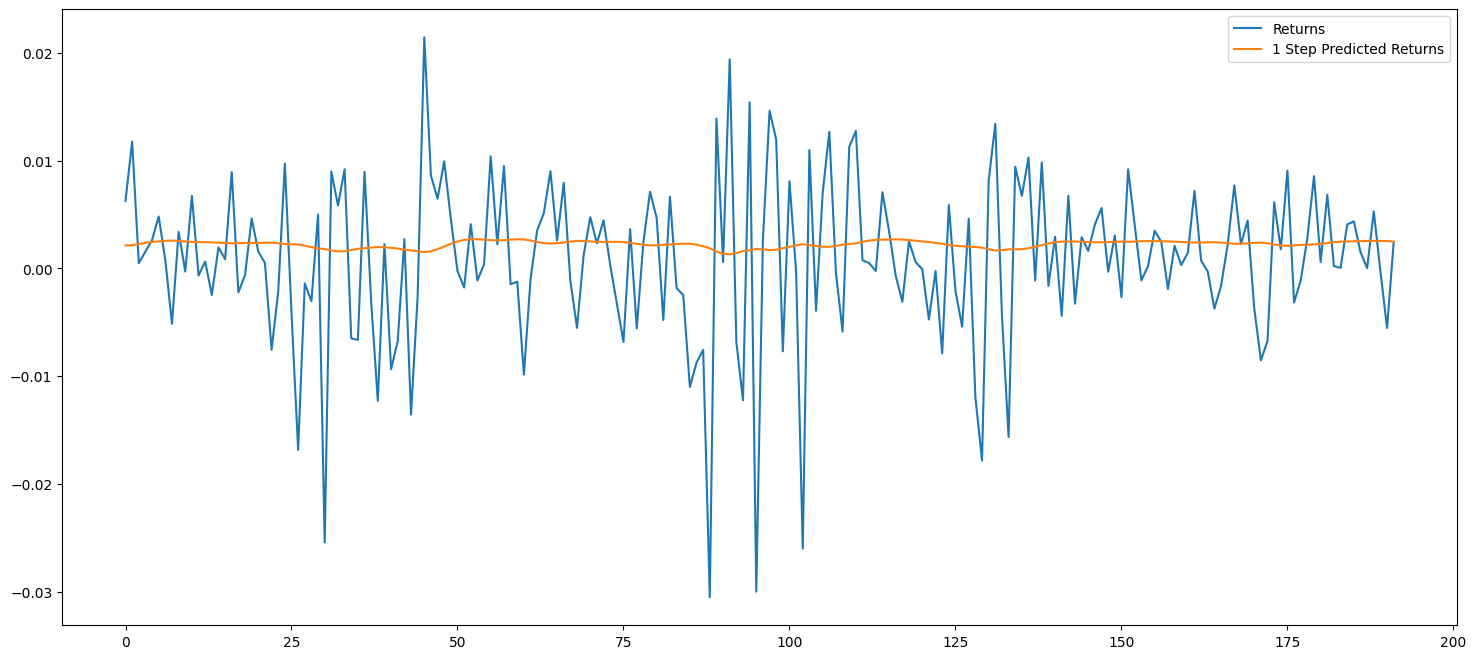

In [110]:
fig = plt.figure(figsize=(18,8))
plt.plot(np.array(spy_data["Log Returns"][split_date:][training_len:]))
plt.plot(predicted_returns)
plt.legend(["Returns", "1 Step Predicted Returns"])

## 2.2 Modelling One Step Volatility

### 2.2.2 Creating Training Data

In [100]:
training_len = 60
X_train = []
y_train = []

X_train = [window for window in spy_data["Realized Volatility Scaled"][:split_date][20:].rolling(window=training_len)][training_len-1:-1]
y_train = spy_data["Realized Volatility Scaled"][:split_date][20:][training_len:]
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### 2.2.3 Forming GRU Model

In [101]:
gru_vol_model = Sequential()

#First GRU Layer
gru_vol_model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_vol_model.add(Dropout(0.3))

#Second GRU Layer
gru_vol_model.add(GRU(units=80, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_vol_model.add(Dropout(0.2))

#Third GRU Layer
gru_vol_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
gru_vol_model.add(Dropout(0.1))

#Fourth GRU Layer
gru_vol_model.add(GRU(units=30, activation='tanh'))
gru_vol_model.add(Dropout(0.2))

#Output Layer
gru_vol_model.add(Dense(units=1))

#Compiling RNN
gru_vol_model.compile(optimizer='adam', loss='mean_squared_error')

### 2.2.4 Testing Model

In [102]:
#Making test data
X_test = []

X_test = [window for window in spy_data["Realized Volatility Scaled"][split_date:].rolling(window=training_len)][training_len-1:-1]
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_vol_transformed = model.predict(X_test)
predicted_vol = vol_scaler.inverse_transform(predicted_vol_transformed)

6/6 [==============================] - 0s 26ms/step


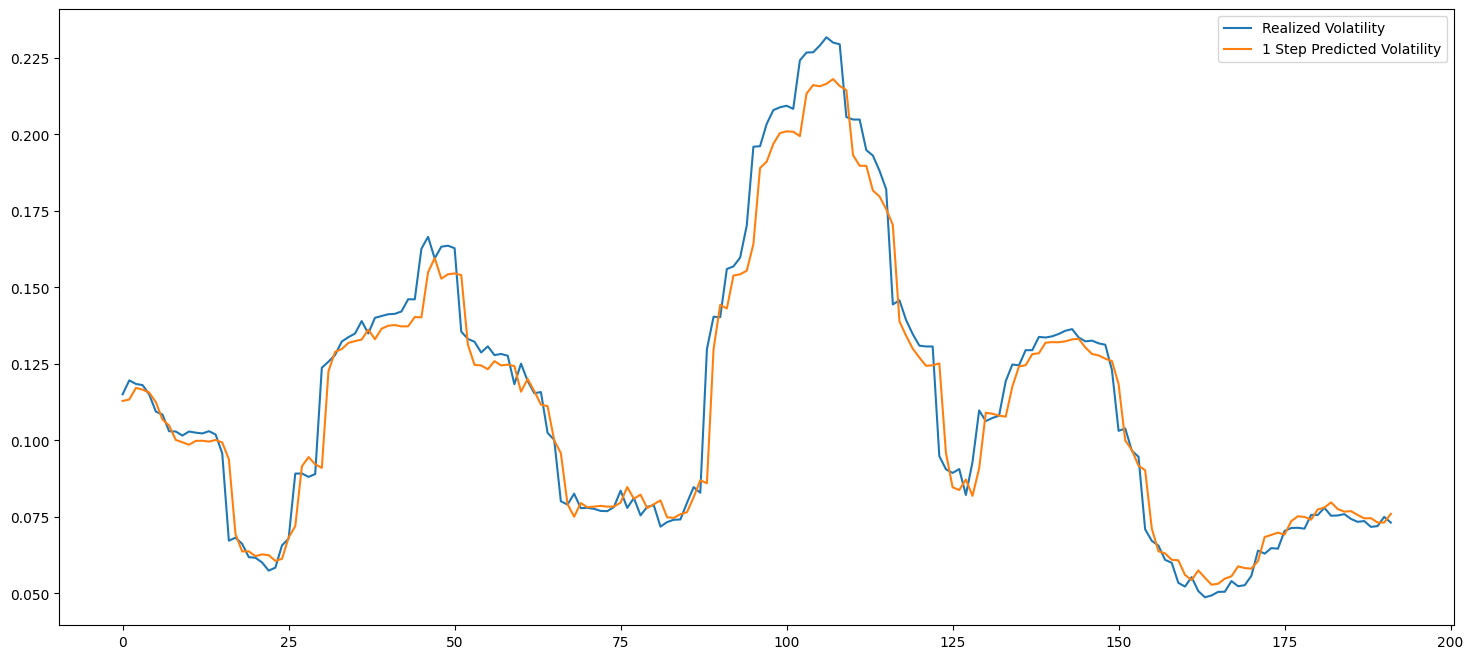

In [103]:
fig = plt.figure(figsize=(18,8))
plt.plot(np.array(spy_data["Realized Volatility"][split_date:][training_len:]))
plt.plot(predicted_vol)
plt.legend(["Realized Volatility", "1 Step Predicted Volatility"])